In [78]:
# data wrangling
import re # regular expressions!

# math and data utilities
import numpy as np
import pandas as pd

# data and statistics libraries
import sklearn.preprocessing as pre
from sklearn import model_selection
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Set-up default visualization parameters
mpl.rcParams['figure.figsize'] = [12,8]
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("whitegrid")

# Initial Setup
We can download the data from Kaggle to our data folder using the command line:

`kaggle competitions download -c titanic`

`unzip titanic.zip`

After that, let's get the data into some Pandas dataframes:

In [79]:
train_df = pd.read_csv('data/train.csv', index_col='PassengerId')
test_df = pd.read_csv('data/test.csv', index_col='PassengerId')

train_df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Lets combine the two dataframes so that we can preprocess all of the data at once.

We will first pop the 'Survived' column from the training data and save it for later. We also want to save indexes of the training/testing dataframes so that we can split them apart again.

In [80]:
survival = train_df.pop('Survived')
train_idx, test_idx = train_df.index, test_df.index

df = pd.concat([train_df, test_df])

# clear memory, now that we don't need these two df's:
del train_df, test_df

# Exploratory Data Analysis and Data Cleaning:

Let's take a first look at our data. We want to know what sort of categorical and continuous information it gives us. We want to know if there is any missing data, or where there is opportunity to create new features based on the old. 

In [81]:
df.head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


### Can we find new and useful ways of describing the same data (Feature Engineering)?

For example, looking at family data, we can tell if a person traveled alone, or with family. We can also determine how many people, if any they traveled with. Let's add these features to our dataframe.

In [82]:
df['FamilySize'] = 1 + df.SibSp + df.Parch
df['Alone'] = df.FamilySize.apply(lambda x: 1 if x==1 else 0)
df['NameLength'] = df['Name'].apply(len)

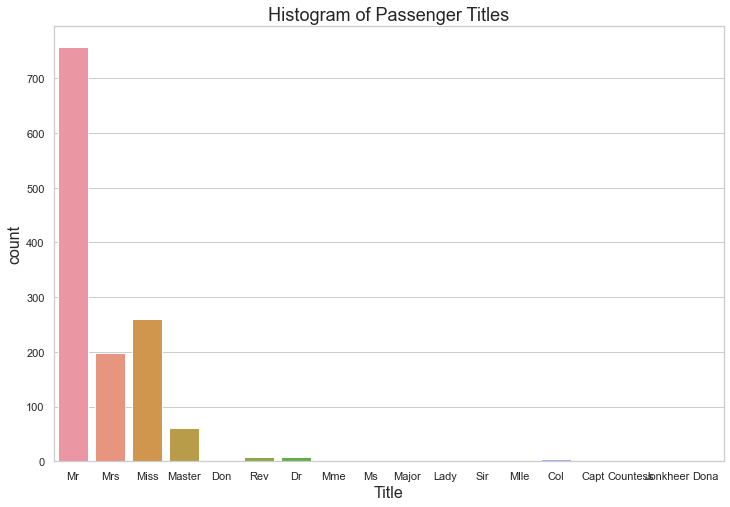

In [83]:
# extract last names and titles:
df['Title'] = df.Name.str.extract(r'([A-Za-z]+)\.')

# extract last name: 
df['LName'] = df.Name.str.extract(r'([A-Za-z]+),')

# Plot histogram of parsed titles:
sns.countplot(df.Title).set_title("Histogram of Passenger Titles")
plt.show()

In [84]:
# Many of these names mean similar things, so let's simplify.

title_dict = {
    'Mrs': 'Mrs', 'Lady': 'Lady', 'Countess': 'Lady',
    'Jonkheer': 'Lord', 'Col': 'Officer', 'Rev': 'Officer',
    'Miss': 'Miss', 'Mlle': 'Miss', 'Mme': 'Miss', 'Ms': 'Miss', 'Dona': 'Lady',
    'Mr': 'Mr', 'Dr': 'Officer', 'Major': 'Officer', 'Capt': 'Officer', 'Sir': 'Lord', 'Don': 'Lord', 'Master': 'Master'
}

df.Title = df.Title.map(title_dict)

Now that we have reduced the synonyms in our titles down to basic English language categories, we can again plot a histogram to see what we've got going on:

Text(0.5, 1.0, 'Histogram of Categorical Data: Title')

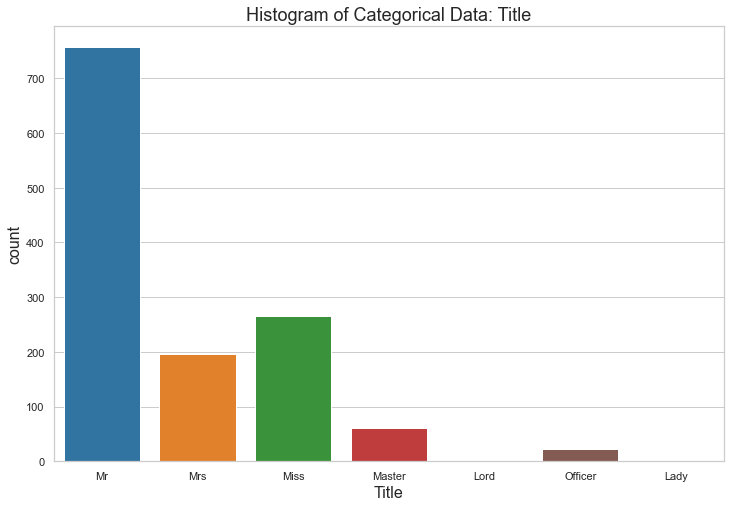

In [85]:
sns.countplot(df.Title).set_title("Histogram of Categorical Data: Title")


In [86]:
# Display the numbers behind the visualization: 
df.Title.value_counts()

Mr         757
Miss       265
Mrs        197
Master      61
Officer     23
Lady         3
Lord         3
Name: Title, dtype: int64

### Feature Engineering Summary:
In summary, we have been able to add four new features (i.e. ways of describing our data): Family size, Traveling Alone, Title and Last Name. We may find some of this extra information quite valuable in the future. 

## Is there any missing data? 
We can see if we are missing any data in our columns by comparing Non-Null Count to the total number of entries. For example, we see below that Age has 1046 Non-Null entries out of a total of 1309 total. That means it's missing 263 data points for Age.

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      1309 non-null   int64  
 1   Name        1309 non-null   object 
 2   Sex         1309 non-null   object 
 3   Age         1046 non-null   float64
 4   SibSp       1309 non-null   int64  
 5   Parch       1309 non-null   int64  
 6   Ticket      1309 non-null   object 
 7   Fare        1308 non-null   float64
 8   Cabin       295 non-null    object 
 9   Embarked    1307 non-null   object 
 10  FamilySize  1309 non-null   int64  
 11  Alone       1309 non-null   int64  
 12  NameLength  1309 non-null   int64  
 13  Title       1309 non-null   object 
 14  LName       1309 non-null   object 
dtypes: float64(2), int64(6), object(7)
memory usage: 203.6+ KB


## Filling in missing Age data:
We might suspect that age is correlated to title. For example, the title "Master" means "boy". We also know that during this era, women typically married earlier in life, implying that a women carrying the title "Miss" might be younger than a "Mrs". We also know that it was more socially acceptable for young women to marry men much older than themselves. These insights may be useful, and we can see if they apply to this particular data set.

Let's explore this concept by looking at the distribution of missing age value by title, and then making some visualizations:

In [88]:
# distribution of missing ages by title:
df.Title[df.Age.isnull()].value_counts()

Mr         176
Miss        51
Mrs         27
Master       8
Officer      1
Name: Title, dtype: int64

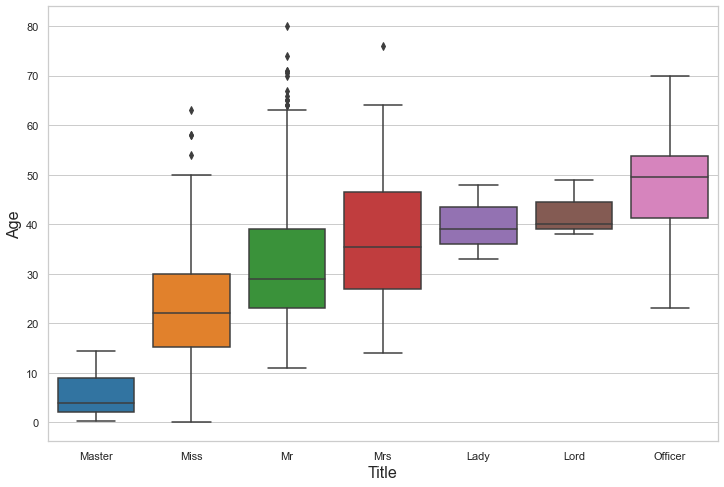

In [89]:
# box plot of title vs age, in order of increasing median
sns.boxplot(x='Title', y='Age', data=df, order=['Officer', 'Lord', 'Lady', 'Mrs', 'Mr', 'Miss', 'Master'][::-1])

### Findings
Indeed, it appears that we can order median age by title. We can use this information to fill in our missing age values according to the average age of a title. Let's take a look at how to do that. 

Our algorithm should look something like this:

__Loop over titles:__

  - __Step 1:__ Compute the average age of all those who hold this title
    
  - __Step 2:__ Find each entry containing this title with no age data.
    
  - __Step 3:__ Add average age from step 1 to these entries. 

In [90]:
# Here is a passenger whose age information is missing:
df.loc[1305]

Pclass                         3
Name          Spector, Mr. Woolf
Sex                         male
Age                          NaN
SibSp                          0
Parch                          0
Ticket                 A.5. 3236
Fare                        8.05
Cabin                        NaN
Embarked                       S
FamilySize                     1
Alone                          1
NameLength                    18
Title                         Mr
LName                    Spector
Name: 1305, dtype: object

In [91]:
# Step 1. for each title, get all rows containing this title where age is null, and the column 'Age'.
# Step 2. From the age column, take the average of all the cells that correspond with current,
# title. 
# Step 3. Fill in the missing data with the average from step 2.

for title in df.Title.unique():
    # get all cells containing this title, with age not null
    df.loc[((df.Age.isnull())&(df.Title==title)), 'Age'] = df.Age[df.Title == title].mean() 

In [92]:
# Let's see if age was succssfully filled in:
df.loc[1305]

Pclass                         3
Name          Spector, Mr. Woolf
Sex                         male
Age                      32.2522
SibSp                          0
Parch                          0
Ticket                 A.5. 3236
Fare                        8.05
Cabin                        NaN
Embarked                       S
FamilySize                     1
Alone                          1
NameLength                    18
Title                         Mr
LName                    Spector
Name: 1305, dtype: object

Sure enough, we have filled in the missing age data with the average age of all other passengers using the title "Mr".

### Filling in missing ticket Fares

There is only one missing data-point for fare, but let's see if we can find a way to fill it in anyway. It seems logical that 1st class tickets cost more than 2nd Class and so on. Does the data support this? In order to find out, we will use the same tactic as when looking at age data.

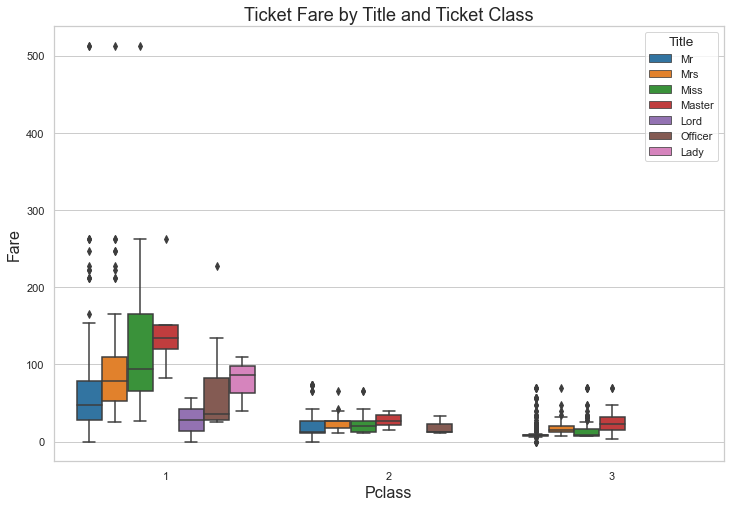

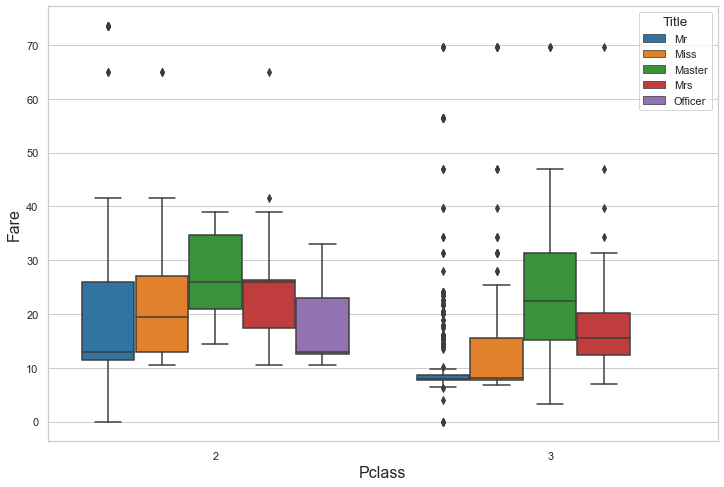

In [93]:
sns.boxplot(x='Pclass', y='Fare', hue='Title', data=df).set_title("Ticket Fare by Title and Ticket Class")
plt.show()
sns.boxplot(x='Pclass', y='Fare', hue='Title', data=df.loc[df.Pclass > 1])
plt.show()

It looks like we can generalize ticket cost by ticket class, which we expected. We can get even more granular, however if we break it down by title... If there was more missing fare data, this might be a good alternative. For now, let's stick with Pclass. 

In [94]:
# Display the single passenger with missing fare data
df.loc[df.Fare.isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,NameLength,Title,LName
PassengerId,,,,,,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,1,18,Mr,Storey


In [95]:
# Since Mr. Storey was in 3rd class, lets fill in his fare price with the average third class ticket price:
df.loc[df.Fare.isnull(), 'Fare'] = df.loc[df.Pclass==3, 'Fare'].mean()
df.loc[1044]

Pclass                         3
Name          Storey, Mr. Thomas
Sex                         male
Age                         60.5
SibSp                          0
Parch                          0
Ticket                      3701
Fare                     13.3029
Cabin                        NaN
Embarked                       S
FamilySize                     1
Alone                          1
NameLength                    18
Title                         Mr
LName                     Storey
Name: 1044, dtype: object

So we see that our missing ticket fare for Mr. Thomas Story is now filled in. Our estimate is that he paid around 13 dollars for his ticket. 

### Filling in missing 'Embarked' data

For simplicity's sake, I'm going to drop Ticket, Cabin and Name from the dataframe. I'm guessing that those fields won't have much impact on the prediction.

In [96]:
df.loc[df.Embarked.isnull(), 'Embarked'] = df.Embarked.mode()[0]

## Summary of EDA and Data Cleaning:

Finally, let's drop any columns we don't plan on using in the future and summarize what we've done so far, by displaying a histogram set of all of our data. Let's also look at correlation visually to see if what we have intuited is based up by the data. 

Because the `DataFrame.hist()` function does not work well on categorical data, we will have to convert our categorical data to numbers first. See below:

In [97]:
# Dropping columns we don't plan to use:
df.drop(['Ticket', 'Name', 'LName', 'Cabin'], axis=1, inplace=True)

# Converting categorical data to numbers:
df['Sex'], int2class_sex = pd.factorize(df.Sex)
df['Title'], int2class_title = pd.factorize(df.Title)
df['Embarked'], int2class_embarked = pd.factorize(df.Embarked)

# To get the categorical data back, simply use the following:
int2class_sex.take(df.Sex)

Index(['male', 'female', 'female', 'female', 'male', 'male', 'male', 'male',
       'female', 'female',
       ...
       'female', 'female', 'female', 'female', 'female', 'male', 'female',
       'male', 'male', 'male'],
      dtype='object', length=1309)

In [98]:
# Let's take a look at our now all numerical data:
df
# survival

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Alone,NameLength,Title
PassengerId,,,,,,,,,,,
1,3,0,22.000000,1,0,7.2500,0,2,0,23,0
2,1,1,38.000000,1,0,71.2833,1,2,0,51,1
3,3,1,26.000000,0,0,7.9250,0,1,1,22,2
4,1,1,35.000000,1,0,53.1000,0,2,0,44,1
5,3,0,35.000000,0,0,8.0500,0,1,1,24,0
...,...,...,...,...,...,...,...,...,...,...,...
1305,3,0,32.252151,0,0,8.0500,0,1,1,18,0
1306,1,1,39.000000,0,0,108.9000,1,1,1,28,6
1307,3,0,38.500000,0,0,7.2500,0,1,1,28,0


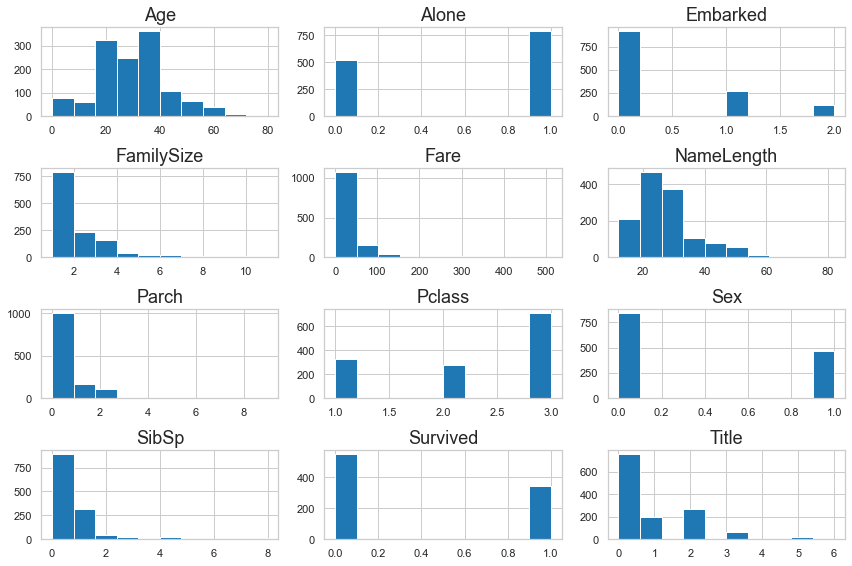

In [99]:

comb_df = pd.concat([df, survival], axis=1)
comb_df.hist()
plt.tight_layout(pad=1)
plt.show()

Now that we've looked at a histogram of our data, let's take a look at our correlation. Using `df.corr()` will give us a nice output of the numeric correlation coefficients, but let's instead use a heat map to make those big correlations really pop visually. 

Notice that in the following code, I am concatenating the survival data back onto the data frame so that we can see how it correlates to our many other variables.

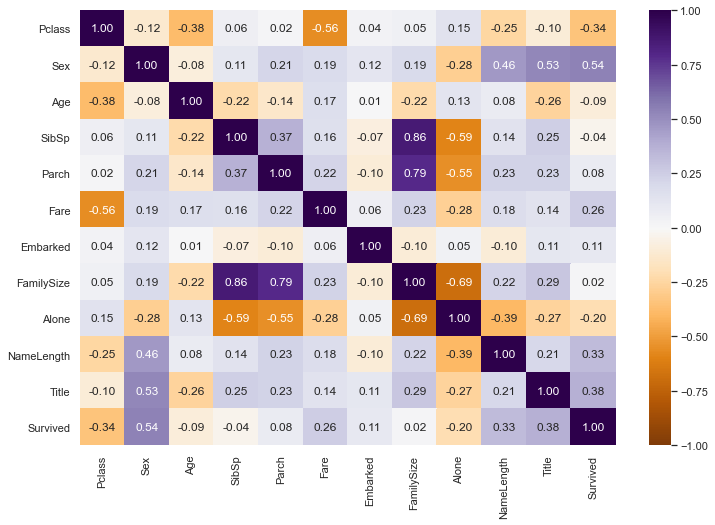

In [100]:
sns.heatmap(pd.concat([df, survival], axis=1).corr(), vmin=-1, vmax=1, cmap="PuOr", annot=True, fmt='0.2f')

What we see probably isn't surprising. There is relatively strong correlation between:
- Ticket class and ticket cost
- Family size and traveling alone
- Families who traveled with children and families that traveled with spouses

And when it comes to correlation between who survived and our variables we see low to medium correlation between:
- Survival and sex
- Survival and title
- Survival and ticket price
- Survival and ticket class
- Survival and Name Length... hmm?

### Thus completes our exploratory data analysis, feature engineering and data cleaning!

# Preparing Our Data for Machine Learning

Now that we have gained some insight into our data and filled in some missing data, we can now begin to think about the Machine Learning step. Our goal is to make it easier for our algorithms to give us good results. One thing that tends to help us with this is centering and normalizing our data. 

This process is called standardization, and it is achieved by subtracting the mean value from each random variable, and then dividing by the standard deviation. In other words, let's say we have a single random variable that we have sampled $n$ times:

### $$ z_i = \frac{x_i - \mu_x}{\sigma}, \hspace{10 mm} i=1 \dots n$$

To set ourselves up for this, let's split out our categorical and continuous features:

In [101]:
categorical_features = ['Pclass', 'Sex', 'Alone', 'Title', 'Embarked']
continuous_features = ['Fare', 'Age', 'NameLength']

Next, let's show a density plot of our data before scaling, so we can compare it to our scaled data later:

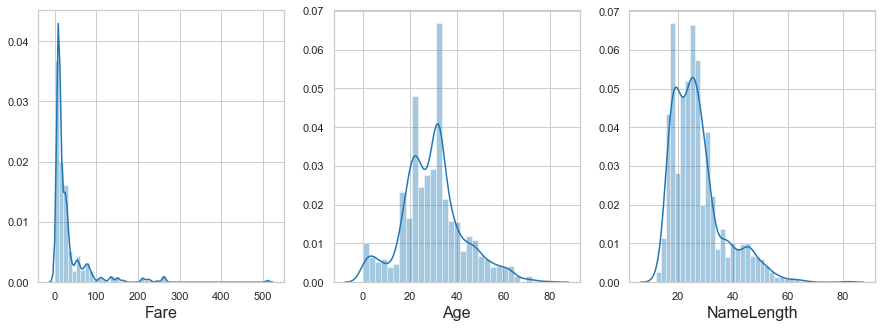

In [102]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
sns.distplot(df[continuous_features].iloc[:,0], ax=axes[0])
sns.distplot(df[continuous_features].iloc[:,1], ax=axes[1])
sns.distplot(df[continuous_features].iloc[:,2], ax=axes[2])

plt.show()

Now that we have the "before" view of our density, let's go ahead ans scale our continuous features. we are going to use scikit-learn's `processing.scale()` method, which essentially applies the mathematical formula above to our data. 

In [103]:
to_scale = df[continuous_features]
scaled_cols = pre.scale(to_scale)
df[continuous_features] = scaled_cols

Now let's take a look at our scaled data. What we should see is that our mean is centered at 0, and that our standard deviation is scaled to 1. Let's look at our new histograms of our continuous features, compared to our previous versions:

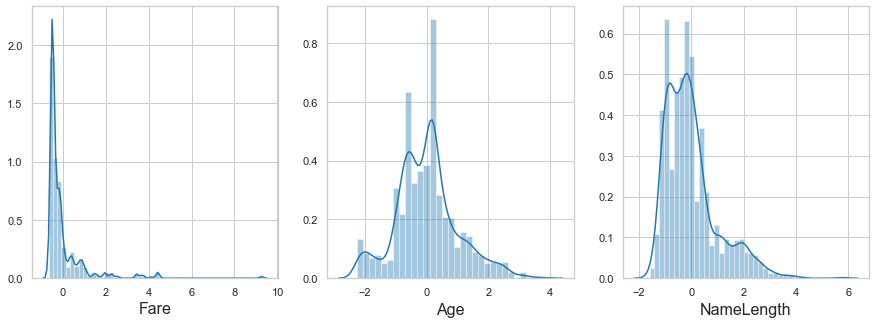

In [104]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
sns.distplot(df[continuous_features].iloc[:,0], ax=axes[0])
sns.distplot(df[continuous_features].iloc[:,1], ax=axes[1])
sns.distplot(df[continuous_features].iloc[:,2], ax=axes[2])
plt.show()

As we can see, the above grafts have there center of mass shifted to 0. 

# Separating Training and Testing Data

In the beginning of this project, we started by with two separate data sets. The training set included data on who survived while the test set did not. Initially, we melded these two sets into a single dataframe with the goal of performing cleaning, feature engineering and preprocessing once on a single dataset. This saved us quite a bit of work, but now we need to split the data back up. Along the way, we saved some structures that would allow us to do that. Let's dive in.

In [105]:
train_df = df.loc[train_idx, :]
test_df = df.loc[test_idx, :]
train_df['Survived'] = survival

del df

In [106]:
# Our complete training dataset
train_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Alone,NameLength,Title,Survived
PassengerId,,,,,,,,,,,,
1,3,0,-0.598610,1,0,-0.503271,0,2,0,-0.434672,0,0
2,1,1,0.614294,1,0,0.734756,1,2,0,2.511806,1,1
3,3,1,-0.295384,0,0,-0.490220,0,1,1,-0.539904,2,1
4,1,1,0.386875,1,0,0.383198,0,2,0,1.775186,1,1
5,3,0,0.386875,0,0,-0.487804,0,1,1,-0.329441,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,0,-0.219577,0,0,-0.392100,0,1,1,-0.645135,5,0
888,1,1,-0.826030,0,0,-0.063420,0,1,1,0.091485,2,1
889,3,1,-0.611153,1,2,-0.190058,0,4,0,1.354261,2,0


In [107]:
# Now let's split our training dataset into independent and target veriables:
X = train_df.drop(['Survived'], axis=1)
Y = train_df['Survived']

In [108]:
# And split our training data into testing and training:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25, random_state=1)

# Setting up a method to evaluate different models:

The goal now, is to iterate through several classifier models and test their efficacy. In order to do that, let's define a function that takes a model, applies it, evaluates the performance and then gives us a dataframe that will display the performance metrics


In [109]:
def evaluate(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    eval_dict = metrics.classification_report(y_test, y_pred, 
                                              labels=[0,1], 
                                              target_names=['Died', 'Survived'],
                                              output_dict=True)
    prob_array = model.predict_proba(x_test)
    
    fpr, tpr, huh = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
    auc = metrics.auc(fpr, tpr)
    eval_dict['AUC'] = auc
    eval_dict['Classifier'] = model
    
    return eval_dict

The above method does the following:

1. It fits the model to the training data.
2. Makes a set of predictions based on the testing data
3. Creates a dictionary containing performance metrics of the tested model
4. Calculates ROC curve 
5. Calculates area under the ROC curve and adds this final metric to the dictionary. 

# Running the Models and Evaluating Performance

Next, we will call our method above on each of our three classifiers and gather their metrics into a single dictionary called `evals`, and print it to see what kind of information we've obtained about our models.

In [110]:
evals = {}
evals['KNN'] = evaluate(KNeighborsClassifier())
evals['Logistic Regression'] = evaluate(LogisticRegression())
evals['Random Forest'] = evaluate(RandomForestClassifier())

# a function to pretty print our dictionary of dictionaries:
def pprint(web, level):
    for k,v in web.items():
        if isinstance(v, dict):
            print('\t'*level, f'{k}: ')
            level += 1
            pprint(v, level)
            level -= 1
        else:
            print('\t'*level, k, ": ", v)
    
#Let's take a look at what we've got
pprint(evals, 0)            

 KNN: 
	 Died: 
		 precision :  0.7345679012345679
		 recall :  0.9296875
		 f1-score :  0.8206896551724138
		 support :  128
	 Survived: 
		 precision :  0.8524590163934426
		 recall :  0.5473684210526316
		 f1-score :  0.6666666666666666
		 support :  95
	 accuracy :  0.7668161434977578
	 macro avg: 
		 precision :  0.7935134588140053
		 recall :  0.7385279605263158
		 f1-score :  0.7436781609195402
		 support :  223
	 weighted avg: 
		 precision :  0.7847905736116669
		 recall :  0.7668161434977578
		 f1-score :  0.7550744806968712
		 support :  223
	 AUC :  0.8219161184210526
	 Classifier :  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
 Logistic Regression: 
	 Died: 
		 precision :  0.8014184397163121
		 recall :  0.8828125
		 f1-score :  0.8401486988847583
		 support :  128
	 Survived: 
		 precision :  0.8170731707317073
		 recall :  0.70526

## Plotting our Metrics to Compare Performance

Now that we have all of our performance metrics for each model in our `evals` dictionary, we want to visually compare how our models did. Because all of that information is contained in a hard to plot nested dictionary, we will take additional steps:

1. Create a DataFrame object from our evaluation dictionary `evals`, which we will call `eval_df`.
2. Pull 3 other metrics from the 'macro avg' sub-dictionary and adds them to our new dataframe `eval_df`.
3. Now `eval_df` contains all of the scoring information from the dictionary, but it also contains other information that we don't care about plotting. We will extract all of the metric information from `eval_df` into a final dataframe called `scores_df`.
4. Finally, we will plot `scores_df` and compare each model's results.

Pulling off step 2 is a little complicated, but you can trace the code below with the dictionary above to get a little insight on how it was achieved.

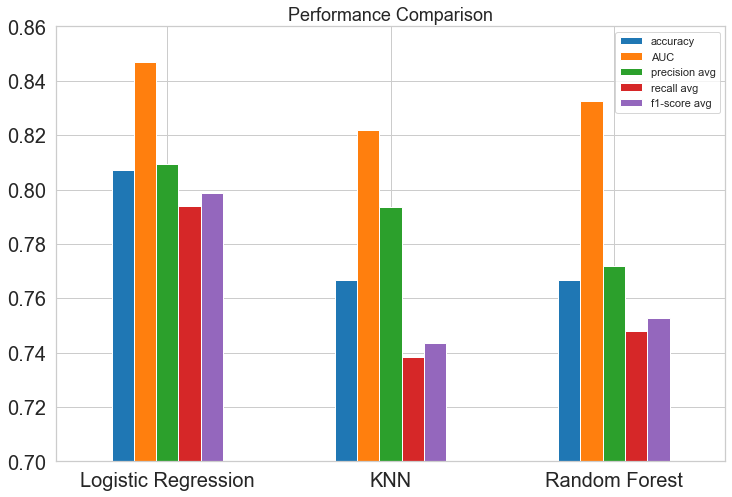

In [112]:
# Step 1:
eval_df = pd.DataFrame.from_dict(evals)

# Step 2:
for metric in ['precision', 'recall', 'f1-score']:
    eval_df = eval_df.append(
        eval_df.loc['macro avg'].apply(
            lambda x: dict(x)[metric]).rename(f'{metric} avg'))

# Step 3
scores_df = eval_df.T.drop(['Survived', 'Died', 'Classifier', 'weighted avg', 'macro avg'], axis=1)
scores_df.sort_values(by='accuracy', ascending=False, inplace=True)

# Step 4
scores_df.plot(kind='bar', fontsize=20, ylim=(0.7, 0.86)).set_title("Performance Comparison")
plt.xticks(rotation=0)
plt.show()

It looks like Logistic Regression significantly out-performed the other two models. Since that appears to be the case, we can look deeper into that model's performance by looking at its confusion matrix. This matrix simply shows us the total number of accurate classifications (True Positive or True Negative) as well as the number of incorrect classifications (False Positive or False Negative).

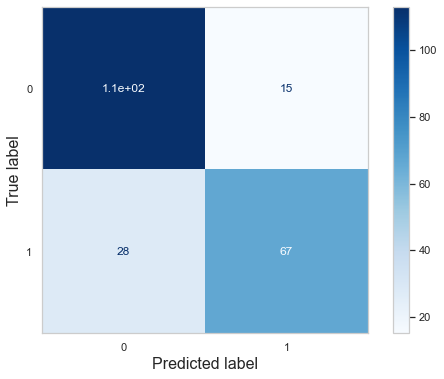

In [113]:
model = eval_df['Logistic Regression']['Classifier']
fig, axis = plt.subplots(figsize=(9, 6))
metrics.plot_confusion_matrix(model, x_test, y_test, cmap='Blues', ax=axis)
plt.grid(None)

What we see is that our model mis-classified 43 total instances of passenger survival. It gave us 28 false negatives and 15 false positives. Divide the number of bad classifications by the total number of samples should give us back our accuracy score: 

### $$1 - \frac{43}{110 + 15 + 28 + 67} = 0.804$$

Looks about right!

# What can be done better?

## Imbalanced Target Variable: Understanding the Distribution of Survival

First, we can take a look at the distribution of actual outcomes, as that might affect our machine learning algorithms:

In [114]:
survival.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

What these numbers mean is that the outcome is skewed towards non-survival. This can lead to our model over-predicting in the direction of non-survival. This did occur, as is apparent by looking at our confusion matrix above. 

There are a couple common solutions to to this problem:

- __Random Under-Sampling:__ If the target variable training data is imbalanced (in our case there were many more deaths than survivals), we can reduce the number of instances of death in our data to more closely match the number of survivals. This will balance our data, but at the cost of losing perhaps valuable data points. 

- __Random Over-Sampling:__ This technique address imbalanced data in the opposite manner. It randomly replicates occurrences of the minority group in order to match the number of occurrences in the majority group. 

Let's try both techniques. Before we get started, let's save the metrics from our first run so we can compare our algorithm's performance after we balance the data.

In [115]:
classifier = LogisticRegression()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)

comp_df =pd.DataFrame({'Accuracy':metrics.accuracy_score(y_test, y_pred),
                       'Precision':metrics.precision_score(y_test, y_pred, average='macro'),
                       'Recall':metrics.recall_score(y_test, y_pred, average='macro'),
                       'f-1':metrics.f1_score(y_test, y_pred, average='macro')},
                      index=['No Sampling'])

comp_df

,Accuracy,Precision,Recall,f-1
No Sampling,0.807175,0.809246,0.794038,0.798605


### Random Under-Sampling:

In [116]:
# Get the unique counts of each class
count_died, count_lived = survival.value_counts()

# Seperate the training data by class
died_df = train_df[train_df.Survived == 0]
lived_df = train_df[train_df.Survived == 1]

#generate random sample of majority class to match the size of the minority class
died_us_df = died_df.sample(count_lived, random_state=1)

# concatinate the undersampled majority dataframe with the minority dataframe
train_us_df = pd.concat([died_us_df, lived_df], axis = 0)

In [117]:
# Display revised survival numbers:
train_us_df.Survived.value_counts()

1    342
0    342
Name: Survived, dtype: int64

### Retraining the Logistic Regression model with under-sampled data:
Now that we have achieved an even distribution through under-sampling the amount of non-survivors, we can go ahead and retrain our model.

In [118]:
# Seperate new targets:
X = train_us_df.drop(['Survived'], axis=1)
Y = train_us_df['Survived']
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=.25, random_state=1)

In [119]:
# Test model on undersampled data:
classifier_us = LogisticRegression()
classifier_us.fit(x_train, y_train)
y_pred = classifier_us.predict(x_test)

# metrics.plot_confusion_matrix(classifier_us, x_test, y_test)
# plt.grid(None)

comp_us_df =pd.DataFrame({'Accuracy':metrics.accuracy_score(y_test, y_pred),
                           'Precision':metrics.precision_score(y_test, y_pred, average='macro'),
                           'Recall':metrics.recall_score(y_test, y_pred, average='macro'),
                           'f-1':metrics.f1_score(y_test, y_pred, average='macro')},
                          index=['Under Sampling'])

comp_df = pd.concat([comp_df, comp_us_df], axis = 0)
comp_df

,Accuracy,Precision,Recall,f-1
No Sampling,0.807175,0.809246,0.794038,0.798605
Under Sampling,0.766082,0.766566,0.766420,0.766074


Now we that we can see our under-sampled results right next to our original scores. There isn't much improvement there. Maybe random over-sampling will get us somewhere. 

### Random Over-Sampling:
The process here is identical to before, except that we are now going to randomly duplicate records in the minority population until we have an equal distribution with the majority population.

In [120]:
# get counts of each class (lived/died)
count_died, count_lived = survival.value_counts()

# seperate data by class
died_df = train_df[train_df.Survived == 0]
lived_df = train_df[train_df.Survived == 1]

# oversample minority class (non-survivors)
lived_os_df = lived_df.sample(count_died, random_state=3, replace=True)

# create new training dataset with oversampled data
train_os_df = pd.concat([died_df, lived_os_df], axis = 0)

### Retraining the Logistic Regression model with over-sampled data:

Getting the hang of this yet? Maybe a little...

In [121]:
X = train_os_df.drop(['Survived'], axis=1)
Y = train_os_df.Survived
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=.25, random_state=1)

In [122]:
classifier_os = LogisticRegression()
classifier_os.fit(x_train, y_train)
y_pred = classifier_os.predict(x_test)

In [123]:
comp_os_df =pd.DataFrame({'Accuracy':metrics.accuracy_score(y_test, y_pred),
                           'Precision':metrics.precision_score(y_test, y_pred, average='macro'),
                           'Recall':metrics.recall_score(y_test, y_pred, average='macro'),
                           'f-1':metrics.f1_score(y_test, y_pred, average='macro')},
                          index=['Over Sampling'])

comp_df = pd.concat([comp_df, comp_os_df], axis = 0)

In [124]:
comp_df

,Accuracy,Precision,Recall,f-1
No Sampling,0.807175,0.809246,0.794038,0.798605
Under Sampling,0.766082,0.766566,0.766420,0.766074
Over Sampling,0.829091,0.828536,0.828780,0.828647


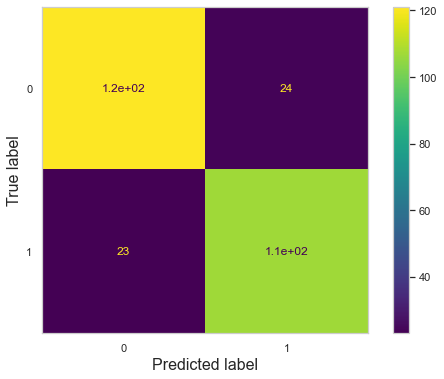

In [125]:
fig, axis = plt.subplots(figsize=(9, 6))
metrics.plot_confusion_matrix(classifier_os, x_test, y_test, ax=axis)
plt.grid(False)

# Drumroll, please...
Let's get our submission!

In [ ]:
y_final = classifier_os.predict(test_df)
submission = pd.DataFrame({'PassengerId':test_df.index,
                           'Survived':y_final})
submission